<a href="https://colab.research.google.com/github/ckraju/Reinforcement-Learning/blob/main/2_PolicyGradients%26Reinforce_ML18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Policy Gradients

---
A policy gradient attempts to train an agent without explicitly mapping the value for every state-action pair in an environment by taking small steps and updating the policy based on the reward associated with that step. The agent can receive a reward immediately for an action or the agent can receive the award at a later time such as the end of the episode.

Formally, let's define a class of parameterized policies: $\Pi = \{\pi_\theta, \theta \in \mathbb{R}^M \}$. Now, for each policy, we define its value as:
$$J(\theta) = \mathbb{E}\big[\sum_{t\geq 0} \gamma^t r_t | \pi_\theta \big]$$

Given this, our objective is to find an optimal policy $\theta* = \arg\max_\theta J(\theta)$. We can achieve this by performing gradient ascent on policy parameters!

### REINFORCE Algorithm
**The Maths (Optional Read)**
Let's try to derive the gradients of our objective function.
$$
\begin{aligned}
J(\theta) &= \mathbb{E}_{\tau \sim p(\tau; \theta)}\big(r(\tau)\big)\\
&= \int_{\tau} r(\tau)p(\tau;\theta)d\tau
\end{aligned}
$$
where, $r(\tau)$ is the reward of a trajectory $\tau = (s_0, a_0, r_0, s_1, \dots)$. Now, let's differentiate this.
$$ \nabla_\theta J(\theta) = \int_{\tau} r(\tau) \nabla_\theta p(\tau; \theta) d\tau $$
This is intractable as gradient of an expectation is problematic when p depends on $\theta$.

However, we can use a nice trick! 
$$\nabla_\theta p(\tau; \theta) = p(\tau; \theta) \frac{\nabla_\theta p(\tau; \theta)}{p(\tau; \theta)} = p(\tau; \theta) \nabla_\theta \log p(\tau; \theta)$$
Now, we can re-write the gradients of our objective function as:
$$
\begin{align}
\nabla_\theta J(\theta) &= \int_\tau \Big(r(\tau) \nabla_\theta \log p(\tau; \theta)\Big) p(\tau; \theta) d\tau \\
&= \mathbb{E}_{\tau \sim p(\tau; \theta)} \big[r(\tau)\nabla_\theta \log p(\tau; \theta)\big]
\end{align}
$$
This term can now be estimated with Monte-Carlo sampling. However, the main challenge here is to compute this quantities without knowing the transition probabilities. Let's take a closer look at $p(\tau; \theta)$
$$ p(\tau; \theta) = \Pi_{t \geq 0} p(s_{t+1}| s_t, a_t)\pi_\theta(a_t|s_t)$$
$$ \log p(\tau; \theta) = \sum_{t \geq 0} \log p(s_{t+1}| s_t, a_t) + \log \pi_\theta(a_t|s_t)$$
and when differentiating, 
$$\nabla_\theta \log p(\tau;\theta) = \sum_{t \geq 0} \nabla_\theta \log \pi_\theta(a_t|s_t)$$
Therefore when sampling a trajectory $\tau$, we can estimate $J(\theta)$ with,
$$\nabla_\theta J(\theta) \approx \sum_{t \geq 0} r(\tau) \nabla_\theta \log \pi_\theta(a_t|s_t)$$

**Interpretation**:

- If $r(\tau)$ is high, push up the probabilities of the actions seen
- If $r(\tau)$ is low, push down the probabilities of the actions seen

**Algorithm**

1. Sample trajectories $\{\tau^i\}$ from $\pi_\theta(a_t|s_t)$. (Run the policy -> forward pass through the network)
2. Compute the estimated gradients, $\nabla_\theta J(\theta) \approx \sum_{i} \sum_{t \geq 0} r(\tau) \nabla_\theta \log \pi_\theta(a_t|s_t)$
3. Update the parameters, $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$

---
### Learning to play Space Invaders
<img src="https://raw.githubusercontent.com/ckraju/Reinforcement-Learning/main/images/space_invaders.png" width=300>

Now let's see how to apply the policy gradient to play an arcade game, space invaders, using OpenAI Gym.

---
#### Working with OpenAI gym
To get you acquanted with OpenAI's gym environment, here are some basic syntax:
1. `env.reset()` - resets the environment
2. `env.step(action)` - applies the given action in the environment which returns four values:<br>
(a) `observation` (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game. <br>
(b) `reward` (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward. <br>
(c) `done` (boolean): whether it's time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.) <br>
(d) `info` (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment's last state change). However, official evaluations of your agent are not allowed to use this for learning.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [7]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars



UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assau

### 2. Define the Architecture of the Policy

In [8]:
env = gym.make('SpaceInvaders-ram-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=128, h_size=256, a_size=6):
        super(Policy, self).__init__()
    
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.d = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.elu(self.d(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)
        return x

    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()    # Sampling from a multinomial distribution
        return action.item(), m.log_prob(action)

observation space: Box(0, 255, (128,), uint8)
action space: Discrete(6)


### 3. Train the Agent with REINFORCE

In [10]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

def reinforce(n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    max_iter_score = 0.0
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= max_iter_score:
            max_iter_score = np.mean(scores_deque)
            print('ep %d: model saving...' % (i_episode))
            torch.save(policy.state_dict(), 'pg_params.pkl')
        
    return scores
    
scores = reinforce()

ep 1: model saving...
ep 2: model saving...
ep 4: model saving...
Episode 100	Average Score: 202.70
Episode 200	Average Score: 205.45
ep 281: model saving...
ep 282: model saving...
ep 283: model saving...
ep 287: model saving...
ep 288: model saving...
ep 289: model saving...
ep 290: model saving...
ep 293: model saving...
ep 294: model saving...
ep 295: model saving...
ep 296: model saving...
ep 297: model saving...
ep 298: model saving...
ep 299: model saving...
Episode 300	Average Score: 243.10
ep 300: model saving...


### 4. Plot the Scores

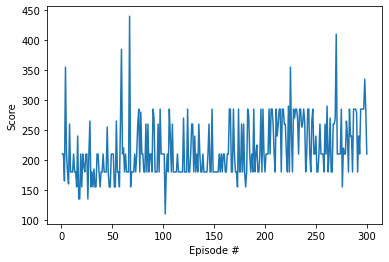

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

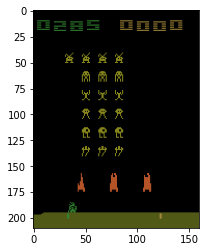

In [12]:
from IPython import display
env = gym.make('SpaceInvaders-ram-v0')
policy.load_state_dict(torch.load('pg_params.pkl'))
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(100000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()